### Introduction to Autoencoders

This tutorial introduces autoencoders with three examples: the basics, **image denoising**, and **anomaly detection**.

An autoencoder is a type of artificial neural network used to learn efficient codings of unlabeled data (unsupervised learning). An autoencoder learns two functions: an encoding function that transforms the input data, and a decoding function that recreates the input data from the encoded representation. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error.

![Autoencoders](https://miro.medium.com/max/600/1*nqzWupxC60iAH2dYrFT78Q.png)

Source: https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f

An optimal autoencoder would perform as close to perfect reconstruction as possible, with "close to perfect" defined by the reconstruction quality function d.

![Reconstruction](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

Source: https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

Load Dataset from Keras library -> Fashion MNIST

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]   # normally x_train.shape is (60000, 28, 28), with adding tf.newaxis we get x_train.shape as (60000, 28, 28, 1)
x_test = x_test[..., tf.newaxis]     # normally x_test.shape is (60000, 28, 28), with adding tf.newaxis we get x_test.shape as (60000, 28, 28, 1)

print(x_train.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1)


In [3]:
noise_factor = 0.2

x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)   # Clips tensor values to a specified min and max.
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)     # Clips tensor values to a specified min and max.

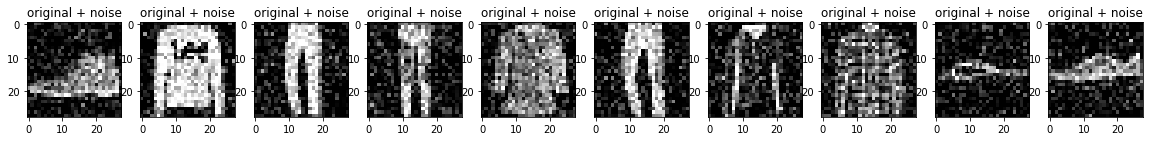

In [4]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a Convolutional Autoencoder

In [5]:
class Denoise(tf.keras.Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    '''
    Conv2DTranspose
    Transposed convolution layer (sometimes called Deconvolution)
    When desire to use a transformation going in the opposite direction of a normal convolution
    '''
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [6]:
# Train the model using x_train as both the input and the target. 
# The encoder will learn to compress the dataset from 784 dimensions to the 
# latent space, and the decoder will learn to reconstruct the original images
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train_noisy, x_train, epochs=10, shuffle=True, validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 23s 5ms/step - loss: 0.0193 - val_loss: 0.0112
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0100 - val_loss: 0.0094
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 4/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0080 - val_loss: 0.0080
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss:

In [7]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [8]:
# The decoder upsamples the images back from 7x7 to 28x28.
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [9]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

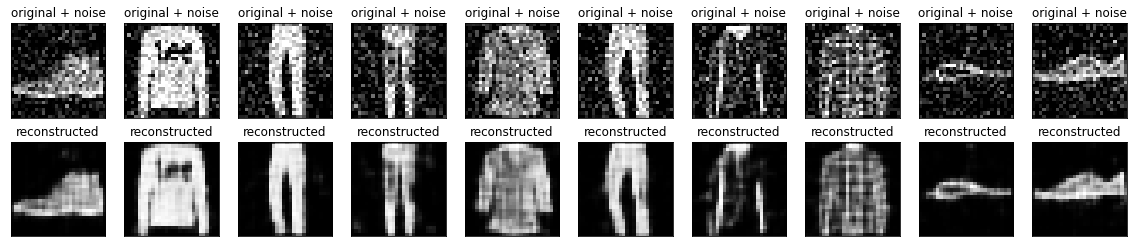

In [10]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

Reference: https://www.tensorflow.org/tutorials/generative/autoencoder?hl=en